Basile LE THIEC

IR 2A Alt.

# TP Data Mining - KAGGLE - Audio Cats and Dogs

### Import librairies

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from PIL import Image
from random import randint

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import noisereduce as nr
import numpy as np
import IPython.display as ipd

import os
import kaggle
import joblib
import librosa
import librosa.display

### Better console messages

In [2]:
from IPython.display import display, HTML

def print_info(msg):
    display(HTML(f"<span style='color:green'><b>[INFO]</b> {msg}</span>"))

def print_warning(msg):
    display(HTML(f"<span style='color:orange'><b>[WARNING]</b> {msg}</span>"))

def print_error(msg):
    display(HTML(f"<span style='color:red'><b>[ERROR]</b> {msg}</span>"))

def print_fatal(msg):
    display(HTML(f"<span style='background-color:red; color:white; padding:2px'><b>[FATAL]</b></span> <span style='color:red'><b>{msg}</b></span>"))

# Usage
print_info("Connection established.")
print_warning("High latency detected.")
print_error("Timeout reached.")
print_fatal("Core dump initiated.")

### Download Dataset Audio Cats and Dogs
[https://www.kaggle.com/datasets/mmoreaux/audio-cats-and-dogs](https://www.kaggle.com/datasets/mmoreaux/audio-cats-and-dogs)

In [3]:
dataset_id = "mmoreaux/audio-cats-and-dogs"
download_path = "./.data"

if not os.path.exists(download_path):
    print_warning(f"Download path '{download_path}' does not exist. Creating directory...")
    os.makedirs(download_path)

dataset_files = ["cats_dogs", "train_test_split.csv"]
files_exist = all(
    os.path.exists(os.path.join(download_path, file)) for file in dataset_files
)

if not files_exist:
    print_warning("Dataset not found. Downloading...")
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(dataset_id, path=download_path, unzip=True)
    print_info("Download completed!")
else:
    print_info("Dataset already exists. Skipping download.")

### Data visualization

In [5]:
audio_eg = f"{download_path}/cats_dogs/train/cat/cat_{randint(1, 167)}.wav"
print_info(f"Playing example audio file: {audio_eg}")
ipd.Audio(audio_eg)

In [6]:
print_info("Loading audio file and extracting basic statistics...")
y, sr = librosa.load(audio_eg)

# Get basic information about the audio
print(f"Audio Length: {len(y) / sr} seconds")
print(f"Sample Rate: {sr}")
print(f"Audio Shape: {y.shape}")

# Calculate some basic statistics
print(f"Mean: {np.mean(y)}")
print(f"Standard Deviation: {np.std(y)}")
print(f"Min: {np.min(y)}")
print(f"Max: {np.max(y)}")

Audio Length: 0.9417233560090703 seconds
Sample Rate: 22050
Audio Shape: (20765,)
Mean: 3.3937471016542986e-05
Standard Deviation: 0.18105252087116241
Min: -1.0083004236221313
Max: 0.916632890701294


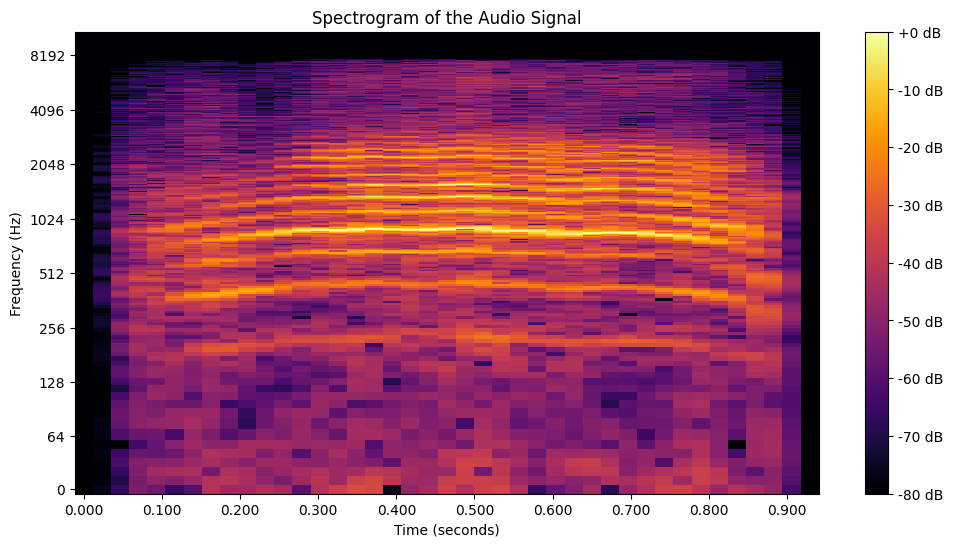

In [7]:
print_info("Visualizing the Spectrogram of the audio signal...")
# Compute the Spectrogram
S = librosa.stft(y)  # Compute Short-Time Fourier Transform (STFT)
D = librosa.amplitude_to_db(np.abs(S), ref=np.max)  # Take magnitude (absolute value) before converting to dB

# Plot the Spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(D, x_axis='time', y_axis='log', sr=sr, cmap='inferno')
plt.title("Spectrogram of the Audio Signal")
plt.colorbar(format='%+2.0f dB')
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.show()

### Data cleanup, organization and preprocessing function

In [8]:
def extract_features_from_directory(directory_path, label):
    features = []
    labels = []

    for file in os.listdir(directory_path):
        if file.endswith('.wav'):
            try:
                file_path = os.path.join(directory_path, file)
                y_audio, sr = librosa.load(file_path, sr=None)
                y_audio = nr.reduce_noise(y=y_audio, sr=sr)
                y_trimmed, _ = librosa.effects.trim(y_audio)
                y_normalized = y_trimmed / max(abs(y_trimmed))
                mfccs = librosa.feature.mfcc(y=y_normalized, sr=sr, n_mfcc=13)
                spectral_centroids = librosa.feature.spectral_centroid(y=y_normalized, sr=sr)
                spectral_rolloff = librosa.feature.spectral_rolloff(y=y_normalized, sr=sr)

                mfccs_mean = np.mean(mfccs, axis=1)
                mfccs_std = np.std(mfccs, axis=1)
                mfccs_min = np.min(mfccs, axis=1)
                mfccs_max = np.max(mfccs, axis=1)
                centroid_mean = np.mean(spectral_centroids)
                centroid_std = np.std(spectral_centroids)
                centroid_min = np.min(spectral_centroids)
                centroid_max = np.max(spectral_centroids)
                rolloff_mean = np.mean(spectral_rolloff)
                rolloff_std = np.std(spectral_rolloff)
                vector = np.hstack([mfccs_mean, mfccs_std, mfccs_min, mfccs_max])
                vector = np.hstack([vector, centroid_mean, centroid_std, centroid_min, centroid_max])
                vector = np.hstack([vector, rolloff_mean, rolloff_std])

                features.append(vector)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {file}: {e}")

    return features, labels

## 0. Load dataset in train and test sets

In [10]:
# Train data
print_info("Extracting features from training data...")
train_cat_path = f"{download_path}/cats_dogs/train/cat"
train_dog_path = f"{download_path}/cats_dogs/train/dog"
X_cat_train, y_cat_train = extract_features_from_directory(train_cat_path, label=0)
X_dog_train, y_dog_train = extract_features_from_directory(train_dog_path, label=1)

X_train = np.array(X_cat_train + X_dog_train)
y_train = np.array(y_cat_train + y_dog_train)


# Test data
print_info("Extracting features from testing data...")
test_cat_path = f"{download_path}/cats_dogs/test/cats"
test_dog_path = f"{download_path}/cats_dogs/test/test"
X_cat_test, y_cat_test = extract_features_from_directory(test_cat_path, label=0)
X_dog_test, y_dog_test = extract_features_from_directory(test_dog_path, label=1)

X_test = np.array(X_cat_test + X_dog_test)
y_test = np.array(y_cat_test + y_dog_test)

## 1. K Nearest Neighbors (KNN) Method

### Find the best hyperparameters for KNN

In [ ]:
# Iterate through the k values, train a k-NN model, and record the accuracy
print_info("Tuning k-NN classifier to find the best k value...")
k_values = range(1, 21)
accuracies = list()

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn_classifier.fit(X_train, y_train)
    knn_y_pred = knn_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, knn_y_pred)
    accuracies.append(accuracy)

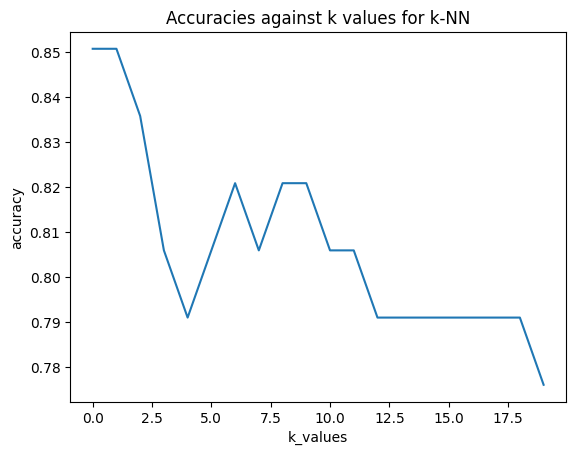

Best k: 1 with accuracy: 0.8507462686567164


In [ ]:
# Plot the accuracies against the k values
print_info("Plotting accuracies against k values...")
plt.plot(accuracies)
plt.xlabel("k_values")
plt.ylabel("accuracy")
plt.title("Accuracies against k values for k-NN")
plt.show()

k = k_values[np.argmax(accuracies)]
print(f"Best k: {k} with accuracy: {max(accuracies)}")

### Train the model

In [ ]:
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [ ]:
# Create a mesh grid for our feature space
X = np.vstack((X_train, X_test))
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict classes for each point in the mesh grid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Visualize the decision boundaries
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50)
plt.title("k-NN Decision Boundaries")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### Save the model to pickle file

In [ ]:
# for test_index in tqdm
# joblib.dump(model_ngram, './.data/sentiment_model.pkl')

## 2. Decision Tree Method

## 3. Bayes Method

## 4. Support Vector Machine Method

## 5. Neural Network Method